# Fake News Classification with Recurrent Convolutional Neural Networks
# Based on: https://towardsdatascience.com/fake-news-classification-with-recurrent-convolutional-neural-networks-4a081ff69f1a

## Import Libraries

In [4]:
import numpy as np
import pandas as pd
import spacy
import en_core_web_md
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Read Data

In [5]:
train = pd.read_csv(r'.\data\fake-news\train.csv')
test = pd.read_csv(r'.\data\fake-news\test.csv')
results = pd.read_csv(r'.\data\fake-news\submit.csv')

train_labels = []
for label in train["label"].values:
    if label == 0:
        train_labels.append(1)
    else:
        train_labels.append(0)
train_labels = np.array(train_labels)        
        
test_labels = []
for label in results["label"].values:
    if label == 0:
        test_labels.append(1)
    else:
        test_labels.append(0)
test_labels = np.array(test_labels)

train.drop('label',axis=1)
train = train.fillna('no data')
test = test.fillna('no data')
train = train.assign(label=train_labels)
test = test.assign(label=test_labels)

data = train.append(test)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26000 entries, 0 to 5199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      26000 non-null  int64 
 1   title   26000 non-null  object
 2   author  26000 non-null  object
 3   text    26000 non-null  object
 4   label   26000 non-null  int32 
dtypes: int32(1), int64(1), object(3)
memory usage: 1.1+ MB


## Exploratory Data Analysis

C:\ProgramData\Anaconda3\envs\paper\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

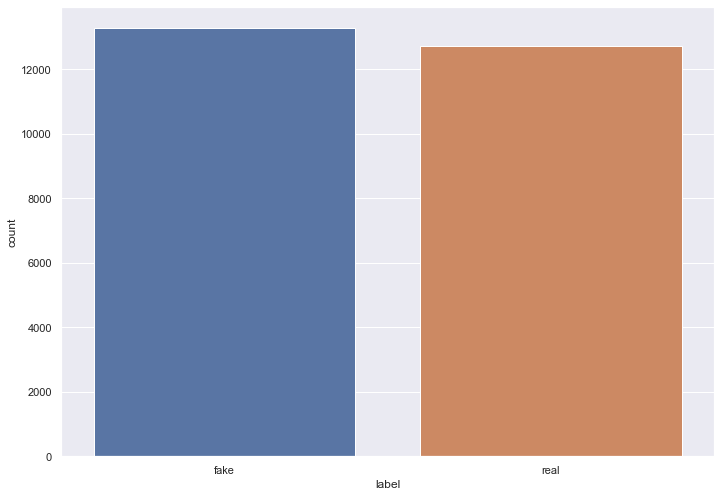

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
conversion_dict = {1: 'real', 0: 'fake'}
sns.countplot(data['label'].apply(lambda x: conversion_dict[x]))

In [7]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
data['length'] = (data['text'] + " " + data['title']).apply(lambda x: len(x.split(' ')))

C:\ProgramData\Anaconda3\envs\paper\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='length', ylabel='Density'>

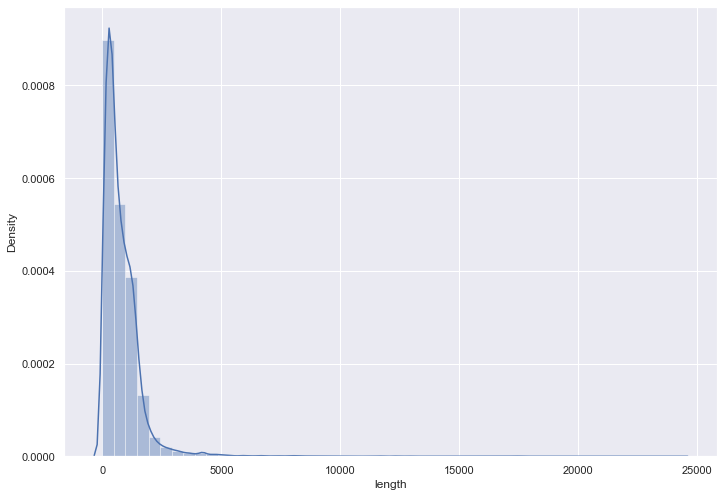

In [8]:
sns.distplot(data['length'])

In [9]:
data['length'].describe()

count    26000.000000
mean       788.382423
std        877.368624
min          3.000000
25%        287.000000
50%        581.000000
75%       1091.000000
max      24243.000000
Name: length, dtype: float64

## Preprocessing the Text Data

In [10]:
import re # regex library
from spacy.lang.en.stop_words import STOP_WORDS

nlp = en_core_web_md.load()

def preprocessor(text):
    text = re.sub('<[^>]*>', '', text) # Effectively removes HTML markup tags
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc if token.text not in STOP_WORDS])
    return text
    
    

In [11]:
X = data['text'] + " " + data['title']
y = data['label']

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

data_processed = pd.DataFrame({'title': data['title'], 'text': X, 'label': y})
data_processed.to_csv('./data/combined_news_data_processed.csv', index=False)

## Topic Modeling with Latent Dirichlet Allocation

In [13]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
import pyLDAvis.sklearn

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

def display_topics_pipeline(pipeline_lda, no_top_words):
    vectorizer = pipeline_lda.steps[0][1]
    lda = pipeline_lda.steps[1][1]
    tf_feature_names = vectorizer.get_feature_names()
    display_topics(lda, tf_feature_names, no_top_words)

### Real News

In [14]:
real_news = data_processed[data_processed['label'] == 1]

num_topics = 10
num_features=5000

vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words='english')
lda = LatentDirichletAllocation(n_components=num_topics,
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0)

lda_pipeline = Pipeline([('vectorizer', vectorizer), ('lda', lda)])
lda_pipeline.fit(real_news['text'])

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.95, max_features=5000, min_df=2,
                                 stop_words='english')),
                ('lda',
                 LatentDirichletAllocation(learning_method='online',
                                           learning_offset=50.0, max_iter=5,
                                           random_state=0))])

### Fake News

In [15]:
fake_news = data_processed[data_processed['label'] == 0]

num_topics = 10
num_features=5000

vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words='english')
lda = LatentDirichletAllocation(n_components=num_topics,
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0)

lda_pipeline = Pipeline([('vectorizer', vectorizer), ('lda', lda)])
lda_pipeline.fit(fake_news['text'])

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.95, max_features=5000, min_df=2,
                                 stop_words='english')),
                ('lda',
                 LatentDirichletAllocation(learning_method='online',
                                           learning_offset=50.0, max_iter=5,
                                           random_state=0))])

## Defining and Training the Model

In [16]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import hashing_trick
from keras.preprocessing.text import text_to_word_sequence
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint

class LSTM_Text_Classifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, embedding_vector_length, max_seq_length, lstm_layers, batch_size=32, num_epochs=3, use_hash=False,
                dropout=None, conv_params=None):
        
        self.embedding_vector_length = embedding_vector_length
        self.max_seq_length = max_seq_length
        self.lstm_layer_sizes = lstm_layers
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.use_hashing_trick = use_hash
        if not self.use_hashing_trick:
            self.tokenizer = Tokenizer()
        self.dropout = dropout
        self.conv_params = conv_params
        
    
    def _get_word_index(self, word):
        
        try:
            return self.tokenizer.word_index[word]
        except:
            return None
        
    def _text_to_int_sequence(self, text):
        seq = [self._get_word_index(word) for word in text_to_word_sequence(text)]
        return [index for index in seq if index]
        
    def fit(self, X, y, validation_data):
        
        all_X = pd.concat([X, validation_data[0]])
        if self.use_hashing_trick:
            all_words = set()
            for text in all_X:
                new_words = set(text_to_word_sequence(text))
                all_words = all_words.union(new_words)
            self.max_vocab = len(all_words)*1.3
            
            for i in range(len(X)):
                X[i] = hashing_trick(X[i], max_vocab, hash_function='md5')
            X_pad = sequence.pad_sequences(X, maxlen=self.max_seq_length)
            
            X_valid = validation_data[0]
            
            for i in range(len(X_valid)):
                X_valid[i] = hashing_trick(X_valid[i], max_vocab, hash_function='md5')
            X_valid_pad = sequence.pad_sequences(X_valid, maxlen=self.max_seq_length)
        
            y_valid = validation_data[1]
            
        else:    
            print('Fitting Tokenizer...')
            self.tokenizer.fit_on_texts(all_X)
            self.max_vocab = len(self.tokenizer.word_index) + 20
            X = X.apply(self._text_to_int_sequence)
            X_pad = sequence.pad_sequences(X, maxlen=self.max_seq_length)
        
            X_valid = validation_data[0].apply(self._text_to_int_sequence)
            X_valid_pad = sequence.pad_sequences(X_valid, maxlen=self.max_seq_length)
        
            y_valid = validation_data[1]
        
        self.model = Sequential()
        self.model.add(Embedding(self.max_vocab, self.embedding_vector_length, input_length=self.max_seq_length))
            
        if self.conv_params is not None:
            use_pooling = False
            if self.conv_params['pool_size'] is not None:
                use_pooling = True
            
            for i in range(self.conv_params['n_layers']):
                self.model.add(Conv1D(filters=2*(i+1)*self.conv_params['filters'], 
                                      kernel_size=self.conv_params['kernel_size'], 
                                      padding='same', activation='relu'))
                if use_pooling:
                    self.model.add(MaxPooling1D(pool_size=self.conv_params['pool_size']))

            
        if len(self.lstm_layer_sizes) > 1:
            for lstm_layer_size in self.lstm_layer_sizes[:-1]:
                self.model.add(LSTM(lstm_layer_size, return_sequences=True))
                self.model.add(Dropout(self.dropout))
            self.model.add(LSTM(self.lstm_layer_sizes[-1]))
        else:
            self.model.add(LSTM(self.lstm_layer_sizes[0]))
        if self.dropout is not None:
            self.model.add(Dropout(self.dropout))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=1,
                              verbose=2, mode='max')
        
        checkpoint = ModelCheckpoint(filepath='best_model',
                                     monitor='val_accuracy',
                                     mode='max',
                                     save_best_only=True)
        
        callbacks_list = [early_stopping, checkpoint]
        print(self.model.summary())
        
        print('Fitting model...')
        self.model.fit(X_pad, y, validation_data=(X_valid_pad, y_valid), 
                  epochs=self.num_epochs, batch_size=self.batch_size, callbacks=callbacks_list)
        
        
    def predict(self, X):
        
        if type(X) == pd.core.frame.DataFrame or type(X) == pd.core.series.Series:
            X = X.apply(self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict(X)
        elif type(X) == str:
            X = self._text_to_int_sequence(X)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict(X)
        else:
            X = map(X, self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict(X)
        
    def predict_classes(self, X):
        
        if type(X) == pd.core.frame.DataFrame or type(X) == pd.core.series.Series:
            X = X.apply(self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_classes(X)
        elif type(X) == str:
            X = self._text_to_int_sequence(X)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_classes(np.array(X))
        else:
            X = map(X, self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_classes(np.array(X))
    
    def predict_proba(self, X):
        
        if type(X) == pd.core.series.Series:
            X = X.apply(self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_proba(X)
        elif type(X) == str:
            X = self._text_to_int_sequence(X)
            X = sequence.pad_sequence(X, maxlen = self.max_seq_length)
            return self.model.predict_proba(np.array(X))
        else:
            X = map(X, self._text_to_word_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_proba(np.array(X))
    
    def load_model(self, file_path):
        
        self.model = load_model(file_path)
    
    def score(self, X, y):
        
        pred = self.predict(X)
        return accuracy_score(y, pred)
    

C:\ProgramData\Anaconda3\envs\paper\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:23: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  serialized_pb=_b('\n,tensorflow/core/framework/tensor_shape.proto\x12\ntensorflow\"z\n\x10TensorShapeProto\x12-\n\x03\x64im\x18\x02 \x03(\x0b\x32 .tensorflow.TensorShapeProto.Dim\x12\x14\n\x0cunknown_rank\x18\x03 \x01(\x08\x1a!\n\x03\x44im\x12\x0c\n\x04size\x18\x01 \x01(\x03\x12\x0c\n\x04name\x18\x02 \x01(\tB\x87\x01\n\x18org.tensorflow.frameworkB\x11TensorShapeProtosP\x01ZSgithub.com/tensorflow/tensorflow/tensorflow/go/core/framework/tensor_shape_go_proto\xf8\x01\x01\x62\x06proto3')
C:\ProgramData\Anaconda3\envs\paper\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:42: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unli

### Model Training

In [17]:
lstm_classifier = LSTM_Text_Classifier(embedding_vector_length=64, max_seq_length=512, dropout=0.1, 
                                            lstm_layers=[128, 128], batch_size=256, num_epochs=3, use_hash=False,
                                           conv_params={'filters': 128, 
                                                        'kernel_size': 5, 
                                                        'pool_size': 2,
                                                        'n_layers': 3})

In [18]:
lstm_classifier.fit(X_train, y_train, validation_data=(X_valid, y_valid))

Fitting Tokenizer...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 64)           15366464  
                                                                 
 conv1d (Conv1D)             (None, 512, 256)          82176     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 256, 256)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 256, 512)          655872    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 128, 512)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None,

INFO:tensorflow:Assets written to: best_model\assets
INFO:tensorflow:Assets written to: best_model\assets


## Validation Results

In [19]:
lstm_classifier.load_model('best_model')

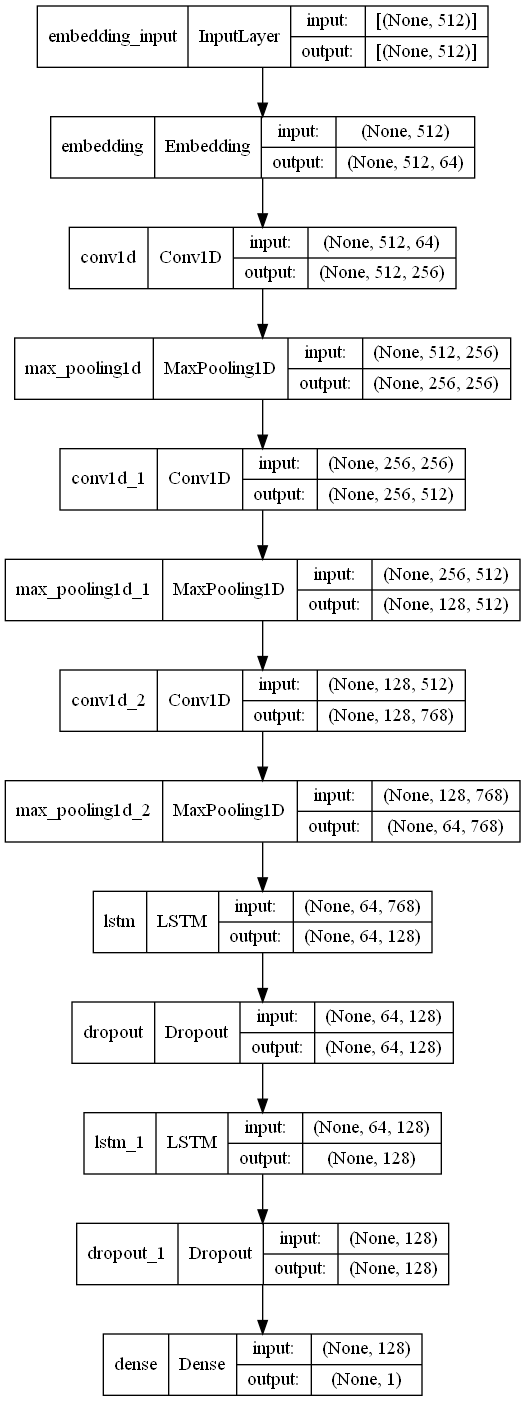

In [20]:
from tensorflow.keras.utils import plot_model
import pydot

plot_model(
    lstm_classifier.model,
    to_file="recurrent_conv_net.png",
    show_shapes=True,
    show_layer_names=True)

In [21]:
import sklearn.metrics as metrics

y_pred = (lstm_classifier.predict(X_valid) > 0.5).astype("int32")

print(metrics.confusion_matrix(y_valid, y_pred))
print(metrics.classification_report(y_valid, y_pred, digits=4))

[[1795  276]
 [ 182 1907]]
              precision    recall  f1-score   support

           0     0.9079    0.8667    0.8869      2071
           1     0.8736    0.9129    0.8928      2089

    accuracy                         0.8899      4160
   macro avg     0.8908    0.8898    0.8898      4160
weighted avg     0.8907    0.8899    0.8898      4160



## Testing Results


Mean accuracy:0.8925


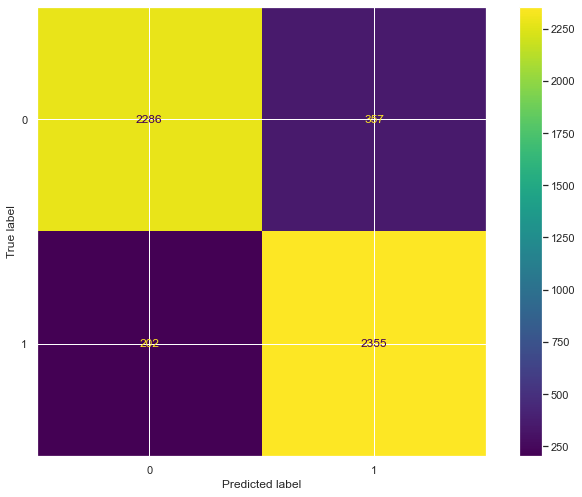

In [22]:
y_pred = (lstm_classifier.predict(X_test) > 0.5).astype("int32")

print("Mean accuracy:" + str(metrics.accuracy_score(y_test, y_pred)))
cm = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()